# Outlier detection in SMACOF solutions

In [1]:
from scripts.ClusterTS_MDS import ClusterMDS

import numpy as np
from sklearn.metrics.cluster import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import HDBSCAN

from matplotlib.pyplot import subplots, colorbar
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True
})

%matplotlib ipympl 

In [2]:
PTEX_dissim = np.loadtxt("./data/PTEX_DTW_matrix.dat", dtype= np.float64, delimiter = ",")
PTEX_dissim.shape

(4313, 4313)

SMACOF-dissim-classic with 10 components has a stress-1 value of 0.033734


np.float64(0.033734198083278)

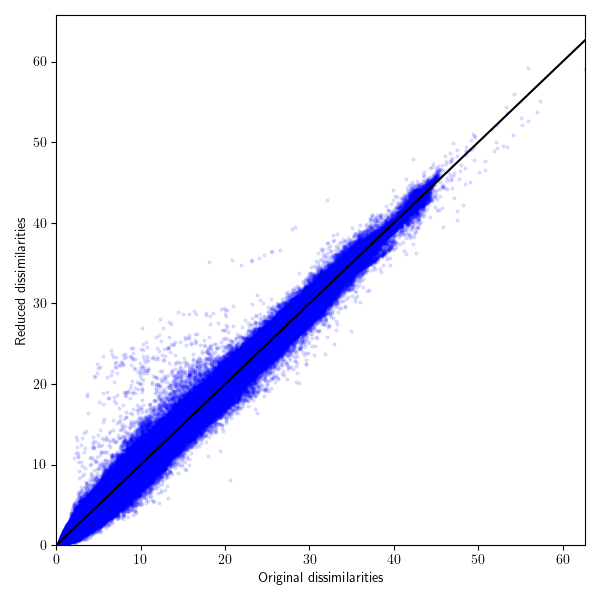

In [3]:
max_num_comps = 10

TEC_ClusterSeries = ClusterMDS(dissimilarity = PTEX_dissim)
TEC_ClusterSeries.ComputeMDS(num_comps_mds = max_num_comps, method = "SMACOF-dissim-classic", max_iter = 1000, eps = 1e-6, verbose = 0)

## Capture of "noise" labelled time series by Callinski-Harabasz index

In [7]:
num_comps_list = tuple(range(2, max_num_comps + 1))
min_cluster_size_list = tuple(range(5, 105, 5))

number_found_clusters = [0]*len(num_comps_list)
optimal_min_cluster_sizes = [0]*len(num_comps_list)
CH_DB_clusters_array = np.zeros((len(num_comps_list), len(min_cluster_size_list), 3))
time_series_index_noise = []

for l, num_comps in enumerate(num_comps_list):
    for k, num_samples in enumerate(min_cluster_size_list):
        HDBSCAN_Out = HDBSCAN(min_cluster_size = num_samples).fit(TEC_ClusterSeries.Xc_TS[:, :num_comps])

        CH_DB_clusters_array[l, k, 0] = calinski_harabasz_score(TEC_ClusterSeries.Xc_TS[:, :num_comps], HDBSCAN_Out.labels_)
        CH_DB_clusters_array[l, k, 1] = davies_bouldin_score(TEC_ClusterSeries.Xc_TS[:, :num_comps], HDBSCAN_Out.labels_)
        CH_DB_clusters_array[l, k, 2] = len(np.unique(HDBSCAN_Out.labels_))

    argmax_CH = np.argmax(CH_DB_clusters_array[l, :, 0])
    optimal_min_cluster_size = min_cluster_size_list[argmax_CH]

    optimal_HDBSCAN_Out = HDBSCAN(min_cluster_size = optimal_min_cluster_size).fit(TEC_ClusterSeries.Xc_TS[:, :num_comps])

    optimal_min_cluster_sizes[l] = optimal_min_cluster_size
    number_found_clusters[l] = len(np.unique(optimal_HDBSCAN_Out.labels_)) - 1
    index_noise = np.argwhere(optimal_HDBSCAN_Out.labels_ == -1)
    if index_noise.size > 0:
        time_series_index_noise.append(index_noise)
    else:
        time_series_index_noise.append([])

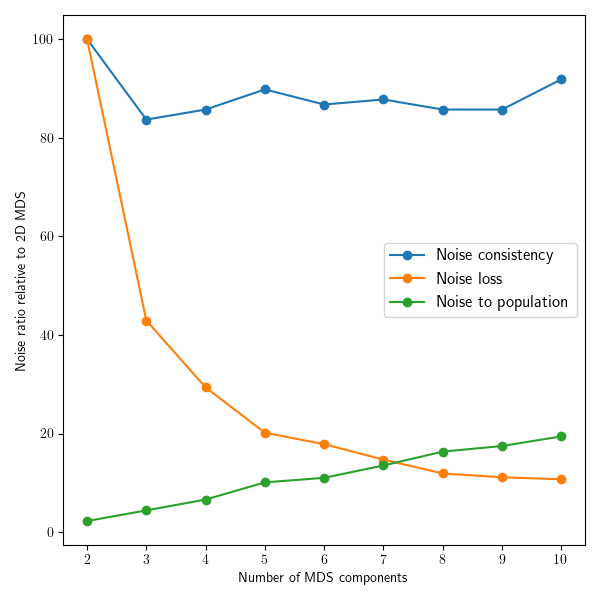

In [13]:
noise_percentage_consistency = [100.0 * np.isin(time_series_index_noise[0], time_series_index_noise[first_index_list]).sum()/time_series_index_noise[0].size for first_index_list in range(len(num_comps_list))]
noise_percentage_loss = [100.0 * np.isin(time_series_index_noise[0], time_series_index_noise[first_index_list]).sum()/time_series_index_noise[first_index_list].size for first_index_list in range(len(num_comps_list))]
noise_percentage_to_pop = [100.0 * time_series_index_noise[first_index_list].size/TEC_ClusterSeries.Xc_TS.shape[0] for first_index_list in range(len(num_comps_list))]

Figure, Subplot = subplots(1, 1, figsize = (6, 6))
Subplot.plot(num_comps_list, noise_percentage_consistency, "-o", label = "Noise consistency")
Subplot.plot(num_comps_list, noise_percentage_loss, "-o", label = "Noise loss")
Subplot.plot(num_comps_list, noise_percentage_to_pop, "-o", label = "Noise to population")
Subplot.legend(loc = "center right", fontsize = 12)

Subplot.set_xlabel("Number of MDS components")
Subplot.set_ylabel("Noise ratio relative to 2D MDS")

Figure.tight_layout()

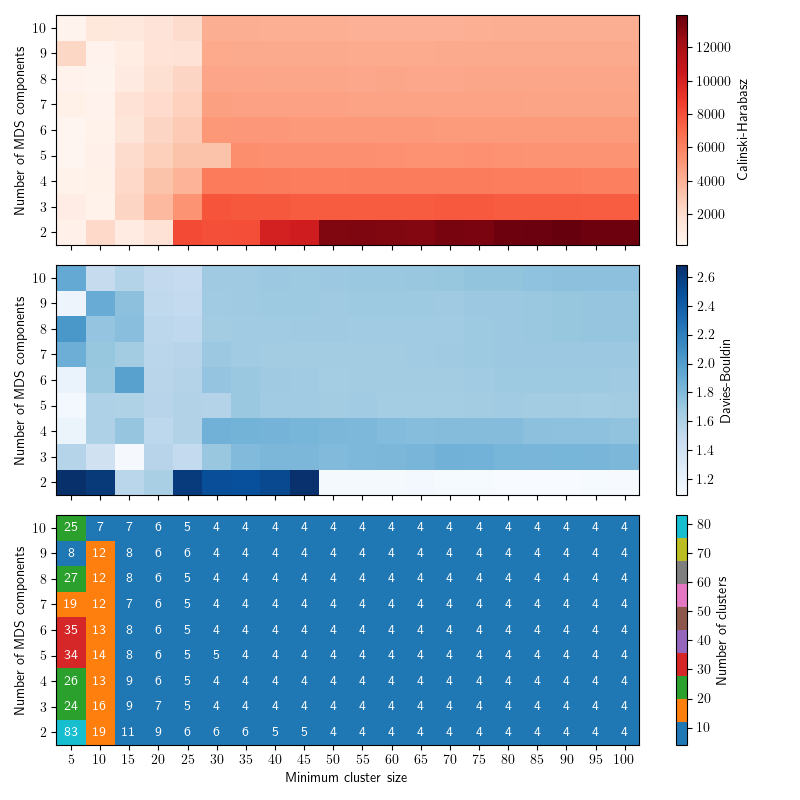

In [9]:
Figure, Subplots = subplots(3, 1, figsize = (8, 8), sharex = True)

Labels = ["Calinski-Harabasz", "Davies-Bouldin", "Number of clusters"]
cmaps = ["Reds", "Blues", "tab10"]

for k in range(3):
    Subplots[k].pcolormesh(min_cluster_size_list, num_comps_list, CH_DB_clusters_array[:, :, k], cmap = cmaps[k], shading = "nearest")

    Subplots[k].set_xticks(min_cluster_size_list)
    Subplots[k].set_yticks(num_comps_list)
    Subplots[k].set_ylabel("Number of MDS components")

    colorbar(Subplots[k].collections[0], ax = Subplots[k], label = Labels[k])

    if k == 2:
        for i, num_comps in enumerate(num_comps_list):
            for j, min_cluster_size in enumerate(min_cluster_size_list):
                value = CH_DB_clusters_array[i, j, k]
                Subplots[k].text(min_cluster_size, num_comps, f"{int(value):d}",
                                ha="center", va="center", color="white", fontsize=10)

Subplots[k].set_xlabel("Minimum cluster size")

Figure.tight_layout()